# Term Project - Milestone #3

Simon Aytes

MAT 328 - Techniques in Data Science

Spring 2022

Professor Owen

----

# 0. Environment configuration

## 0.1 Import libraries

In [41]:
# Data handling
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# Models
from sklearn.neighbors import KNeighborsClassifier

# Model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Feature selection
from sklearn.feature_selection import RFE

# Visualization
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt

# Environment setup
%matplotlib inline
pd.set_option('display.max_columns', None)

## 0.2 Load data

In [3]:
# Get path to the repository's data folder
data_path = "/".join(os.getcwd().split("/")[0:-1]) + "/data/"

In [4]:
chd = pd.read_csv(f"{data_path}processed/model_data.csv")

In [5]:
chd.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0.105263,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.400862,0.836634,0.754098,0.697638,0.431034,0.437500,0.0
1,0.368421,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.564655,0.321782,0.311475,0.203150,0.706897,0.734375,0.0
2,0.473684,1.0,1.0,0.4,0.0,0.0,1.0,0.0,0.491379,0.737624,0.590164,0.618373,0.362069,0.734375,1.0
3,0.842105,0.0,1.0,0.6,0.0,0.0,0.0,0.0,0.525862,0.524752,0.540984,0.521785,0.396552,0.468750,0.0
4,0.105263,1.0,1.0,0.7,0.0,0.0,0.0,0.0,0.758621,0.183168,0.262295,0.612598,0.224138,0.250000,0.0


## 0.3 Utility functions

In [8]:
def rfe_selection(model, data):
    # Assign data-related variables
    features = ["age", "sex", "is_smoking", "cigsPerDay", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose", "TenYearCHD"]
    df_vals = data.values

    # Identify the column names of the features
    inputs = df_vals[:,0:len(features)-1]
    response_variable = df_vals[:,len(features)-1]

    # Feature extraction
    #dt_classifier = DecisionTreeClassifier(max_depth = 5)
    rfe = RFE(model, step = 3)
    fit = rfe.fit(inputs, response_variable)

    # Create list with the target feature names
    selected_features = list(np.array(features[:-1])[np.array(fit.support_)])
    
    # Return a list containing the column names of the most relevant features
    return selected_features

# 1. K-Nearest Neighbor clustering

----

## 1.1 Split model data

In [28]:
# Split data before evaluation for consistency in results
knn_x = chd.drop(columns = ["TenYearCHD"]) #Use columns identified above
knn_y = chd[["TenYearCHD"]]

knn_x_train, knn_x_test, knn_y_train, knn_y_test = train_test_split(knn_x, knn_y, test_size=0.2, random_state = 42)

## 1.2 Determine ideal value of `k`

In [29]:
# Create empty lists
k_list = []
model_error = []

# Loop through each depth
for k in range(2,21):
    # Append the depth to the list
    k_list.append(k)
    
    # Create and fit model
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier = knn_classifier.fit(knn_x_train, np.ravel(knn_y_train))
    
    # Test model and log error
    knn_y_pred = knn_classifier.predict(knn_x_test)
    model_error.append(accuracy_score(knn_y_pred, np.ravel(knn_y_test)))

Text(0, 0.5, 'Accuracy')

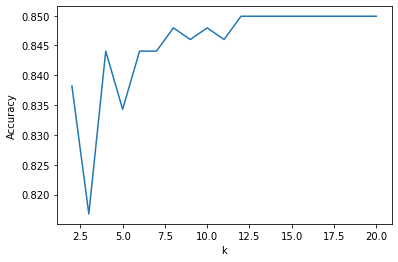

In [72]:
plt.plot(k_list, model_error)
plt.xlabel("k")
plt.ylabel("Accuracy")

## 1.3 Train classifier

In [35]:
knn = KNeighborsClassifier(n_neighbors = k_list[model_error.index(max(model_error))])
knn = knn.fit(knn_x_train, np.ravel(knn_y_train))

## 1.4 Evaluate model performance

In [36]:
# Predict test data with classifier
knn_y_pred_test = knn.predict(knn_x_test)

In [49]:
# Calculate the accuracy of the model
knn_classifier_accuracy = accuracy_score(knn_y_pred_test, knn_y_test)

# Output accuracy
print(f"KNN Classifier Accuracy (d={k_list[model_error.index(max(model_error))]}): {knn_classifier_accuracy}")

KNN Classifier Accuracy (d=12): 0.8499025341130604


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'Actual')]

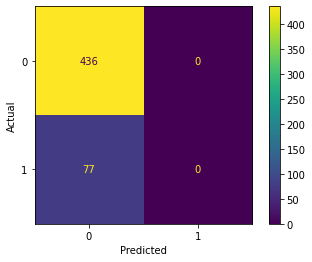

In [47]:
cm = confusion_matrix(knn_y_test, knn_y_pred_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='Actual')

In [40]:
print(classification_report(knn_y_test, knn_y_pred_test))

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       436
         1.0       0.00      0.00      0.00        77

    accuracy                           0.85       513
   macro avg       0.42      0.50      0.46       513
weighted avg       0.72      0.85      0.78       513



/Users/simon/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 2. New graph

In [70]:
# Get path to the repository's data folder
fig_path = "/".join(os.getcwd().split("/")[0:-1]) + "/figures/"

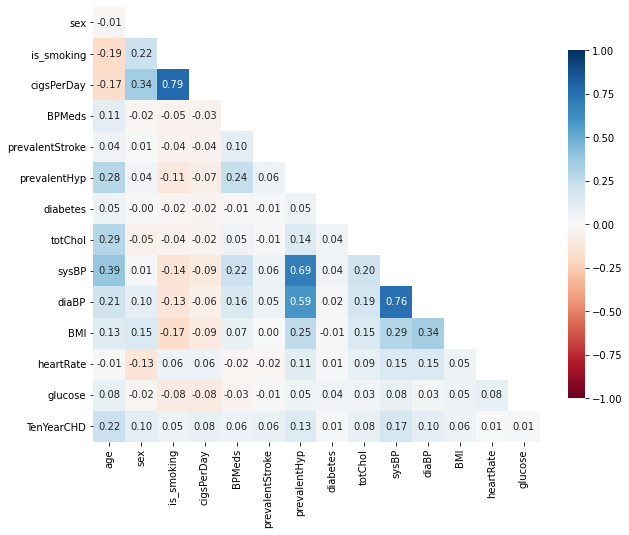

In [71]:
# Create figure and correlation matrix
corr = chd.corr()
fig, ax = plt.subplots(figsize=(10, 8))

# Create mask to remove all duplicated correlations
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
mask = mask[1:, :-1]

# Create hte heatmap
corr = corr.iloc[1:,:-1].copy()
heatmap = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu', vmin=-1, vmax=1, cbar_kws={"shrink": .8})

# Save figure
plt.savefig(f'{fig_path}correlation_plot.jpeg', dpi=300)

# Plot the graph
plt.yticks(rotation=0)
plt.show()